<a href="https://colab.research.google.com/github/MarkosBont/brain_tumour_model/blob/main/Brain_Tumor_Model_ECM2423.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This section focuses on importing the zip file from the user's local machine
from google.colab import files
import zipfile

uploaded = files.upload() # Will give the user a prompt to upload the zip file

# Extracting the dataset from the zip file
with zipfile.ZipFile("brain_tumor_dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

# Defining the path for the dataset, this is the structure since there is the brain_tumor_dataset folder within the zip, and not directly the yes, no folders
dataset_path = "/content/brain_tumor_dataset/brain_tumor_dataset"

print("Dataset uploaded, the path is " + dataset_path) # Ensuring that there are no errors with the upload of the file


Saving brain_tumor_dataset.zip to brain_tumor_dataset (8).zip
Dataset uploaded, the path is /content/brain_tumor_dataset/brain_tumor_dataset


In [ ]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

# Creating paths for the train, validation, test folders
base_dir = "/content/split_dataset"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Creating the 6 folders needed for training, validation, testing, each one with a yes and no subfolder.
for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(folder, "yes"), exist_ok=True)
    os.makedirs(os.path.join(folder, "no"), exist_ok=True)


# Getting the 'yes' and 'no' images from the initial dataset
yes_images = os.listdir(os.path.join(dataset_path, "yes"))
no_images = os.listdir(os.path.join(dataset_path, "no"))


"""
A function which splits the files into training, validation, testing sets and then moves these files to each of the 6 folders previously created.

Using a random_state value means that the data will be split the same way every time.
"""
def split_and_move(files, category):
    train_files, temp_files = train_test_split(files, test_size=0.3, random_state=10) # Splits the files into training (70% of files) and the rest 30% into a temporary file.
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=10) # Splits the temporary file in half, used for validation (15%) and testing (15%).

    # For each file (f) in each folder, it is moved into the directory (creating 6 folders)
    for f in train_files:
        shutil.move(os.path.join(dataset_path, category, f), os.path.join(train_dir, category, f)) # Moves all the training files into the training directory
    for f in val_files:
        shutil.move(os.path.join(dataset_path, category, f), os.path.join(val_dir, category, f)) # Moves all the validation files into the validation directory
    for f in test_files:
        shutil.move(os.path.join(dataset_path, category, f), os.path.join(test_dir, category, f)) # Moves all the testing files into the validation directory

split_and_move(yes_images, "yes")
split_and_move(no_images, "no")

print("The dataset has been split into 6 folders")



The dataset has been split into 6 folders


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224) # Defining the size of the images
BATCH_SIZE = 20 # Defining how many images can be processed at once

data_generator = ImageDataGenerator(rescale=1./255) # This normalizes the pixels of each image, so that they are all in the range 0 to 1.

# Loading the data for training, valdiation, and testing
train_generator = data_generator.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary' # Here shuffle is automatically = True, meaning that different images are used in each epoch for training
)

val_generator = data_generator.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary'
)

# Here I have set shuffle = False in order to have steady testing data which is in the same order every time.
test_generator = data_generator.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', shuffle = False
)


Found 205 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Found 65 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# I am creating a convolutional neural network (CNN) model which allows for feature extraction, and then classifying the images using fully connected layers
model = Sequential([
                    Conv2D(16, (3,3), activation='relu', input_shape=(224,224,3)), # Creating the first convolutional layer, with 16 filters to find basic patterns
                    MaxPooling2D(2,2), # Adding a pooling layer to reduce the size of the feature maps that are produced

                    # The size of the filters doubles each time in order to find more complex patterns in the images
                    Conv2D(32, (3,3), activation='relu'),
                    MaxPooling2D(2,2),

                    Conv2D(64, (3,3), activation='relu'),
                    MaxPooling2D(2,2),

                    Conv2D(128, (3,3), activation='relu'),
                    MaxPooling2D(2,2),

                    # Below begins the fully connected layers, with dropout layers in between them to help reduce overfitting.

                    Flatten(), # This is needed in order to transform the 2D feature maps into a 1D input which can be processed by the fully connected layers
                    Dense(128, activation = 'relu'),
                    Dropout(0.4),
                    Dense(64, activation = 'relu'),
                    Dropout(0.4),
                    Dense(32, activation = 'relu'),

                    Dense(1, activation = 'sigmoid') # The Sigmoid activation function is used to generate a value from 0 (No Tumor) to 1 (Tumor) and thus classify the image
                    ])

# Creating the model, using the Adam optimizer and a learning rate of 0.0001.
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


EPOCHS = 10
BATCH_SIZE = 20 # As before in the dataset (processes 20 images at a time)

# Training the model
history = model.fit(
    train_generator,  # Training dataset
    validation_data=val_generator,  # Validation dataset
    epochs=EPOCHS
)

test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)
print("Test Loss: ", test_loss)





Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 625ms/step - accuracy: 0.6436 - loss: 0.6630 - val_accuracy: 0.6667 - val_loss: 0.6152
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 607ms/step - accuracy: 0.6516 - loss: 0.6330 - val_accuracy: 0.6667 - val_loss: 0.5895
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 560ms/step - accuracy: 0.6195 - loss: 0.6112 - val_accuracy: 0.6667 - val_loss: 0.5806
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 615ms/step - accuracy: 0.6574 - loss: 0.5762 - val_accuracy: 0.6667 - val_loss: 0.5870
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 621ms/step - accuracy: 0.6877 - loss: 0.5470 - val_accuracy: 0.7833 - val_loss: 0.5569
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 571ms/step - accuracy: 0.7118 - loss: 0.6230 - val_accuracy: 0.7667 - val_loss: 0.5429
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 619ms/step - accuracy: 0.7465 - loss: 0.5450 - val_accuracy: 0.7500 - val_loss: 0.5563
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 642ms/step - accuracy: 0.7524 - loss: 0.4970 - val_accuracy: 0.7667 - v

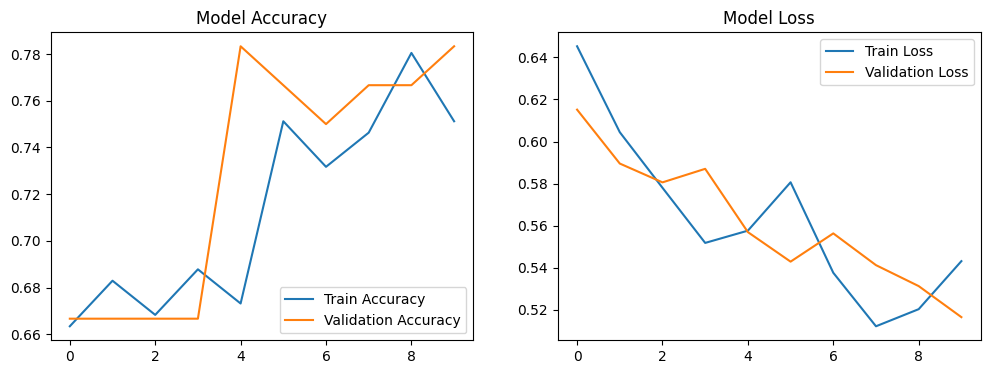

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 4)) # Size of the plot (including two plots)

# Plotting Training vs. Validation Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy') # Getting the accuracy values
plt.plot(history.history['val_accuracy'], label='Validation Accuracy') # Getting the validation accuracy values
plt.legend()
plt.title('Model Accuracy')

# Plotting Training vs. Validation Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss') # Getting the loss values
plt.plot(history.history['val_loss'], label='Validation Loss') # Getting the validation loss values
plt.legend()
plt.title('Model Loss')

plt.show()